In [45]:
# import pakietów
import pandas as pd
import numpy as np 
import nltk
import string
import seaborn as sns
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score


from nltk.corpus import stopwords

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [46]:
# wczytanie danych
data = pd.read_csv('twitter.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [47]:
data.shape

(14640, 15)

In [48]:
# tworzę nową tabelę z wartościami w kolumnie airline_sentiment_confidence =1, aby mieć pewność co do przypisania
# twittów. 
data_conf = data[data['airline_sentiment_confidence'] == 1] 
data_conf.shape

(10445, 15)

In [49]:
# porównanie danych pierwotnych i po usunięciu części wierszy
print("Dane pierwotne: ",data['airline_sentiment'].value_counts())
print()
print("Dane pierwotne: ", data['airline'].value_counts())
print()
print()
print("Dane pewne: ", data_conf['airline_sentiment'].value_counts())
print()
print("Dane pewne: ", data_conf['airline'].value_counts())

Dane pierwotne:  negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Dane pierwotne:  United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64


Dane pewne:  negative    7382
neutral     1548
positive    1515
Name: airline_sentiment, dtype: int64

Dane pewne:  United            2738
US Airways        2258
American          2091
Southwest         1633
Delta             1400
Virgin America     325
Name: airline, dtype: int64


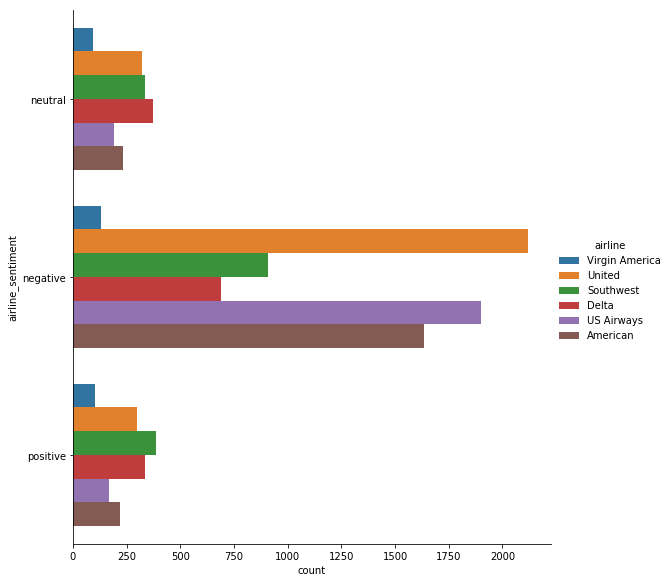

In [50]:
# wykres liczby opinii z rópżnych kategorii dla każdej lini lotniczej
sns.catplot(y="airline_sentiment", hue="airline", kind="count",data=data_conf, height = 8);

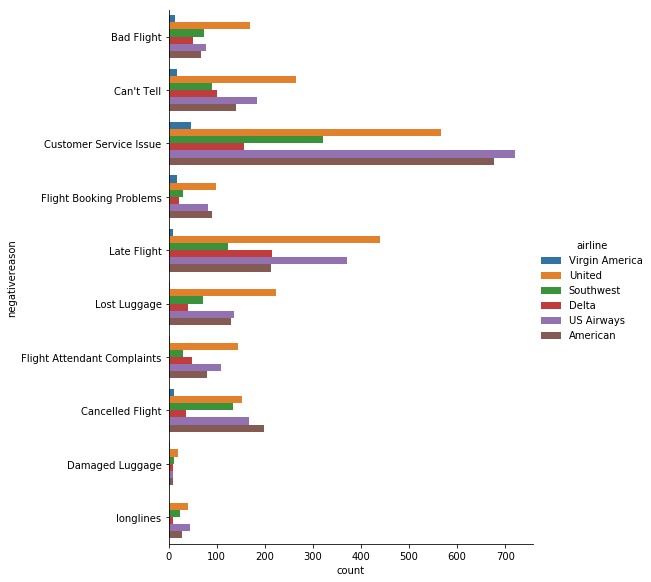

In [51]:
# wykres powodów niegatywnych opinii, ku mojemy zdziwniu przewaza obsługa klienta :)
sns.catplot(y="negativereason", hue="airline", kind="count",data=data_conf, height = 8);

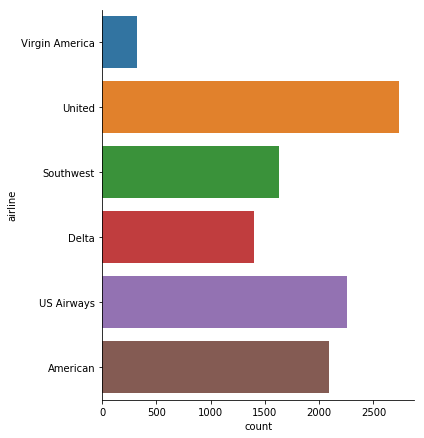

In [52]:
# liczba opinii o poszczególnych liniach
sns.catplot(y="airline", kind="count",data=data_conf, height = 6);

In [53]:
# tabela przestawna przedstawiająca liczbę poszczególnych opinii dla każdej z linii lotniczych
pd.pivot_table(data_conf,index=['airline'],columns = ['airline_sentiment' ],values = ['airline_sentiment_confidence'], aggfunc = [len])

len                 
                  airline_sentiment_confidence                 
airline_sentiment                     negative neutral positive
airline                                                        
American                                1635.0   235.0    221.0
Delta                                    688.0   374.0    338.0
Southwest                                909.0   337.0    387.0
US Airways                              1901.0   190.0    167.0
United                                  2120.0   320.0    298.0
Virgin America                           129.0    92.0    104.0

In [54]:
# swtorzenie nowej tabeli z informacją czy opinia jest negatywna, czy nie (pozytywne i neutralnę łącze do jednej kategorii)
def opinion(row):
    if (row['airline_sentiment'] == 'positive' or row['airline_sentiment'] == 'neutral'):
        return 0
    else:
        return 1

data_conf['Opinion'] = data_conf.apply(opinion, axis=1)    

# usuwam niewykorzystywane dalej kolumny
data_conf = data_conf.drop(data_conf.columns[:9],axis=1) 
data_conf = data_conf.drop(data_conf.columns[[0,2,3,4,5]],axis=1) 
data_conf.head()

,text,Opinion
0,@VirginAmerica What @dhepburn said.,0
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1
5,@VirginAmerica seriously would pay $30 a fligh...,1
9,"@VirginAmerica it was amazing, and arrived an ...",0


In [55]:
# zmieniam wielkość wszystkich liter na małe
data_conf['text'] = data_conf['text'].str.lower()

# usuwam słowa zaczynające sie na @
data_conf['text'] = data_conf['text'].map(lambda x:re.sub('@\w*','',str(x)))

data_conf.head()

,text,Opinion
0,what said.,0
3,"it's really aggressive to blast obnoxious ""en...",1
4,and it's a really big bad thing about it,1
5,seriously would pay $30 a flight for seats th...,1
9,"it was amazing, and arrived an hour early. yo...",0


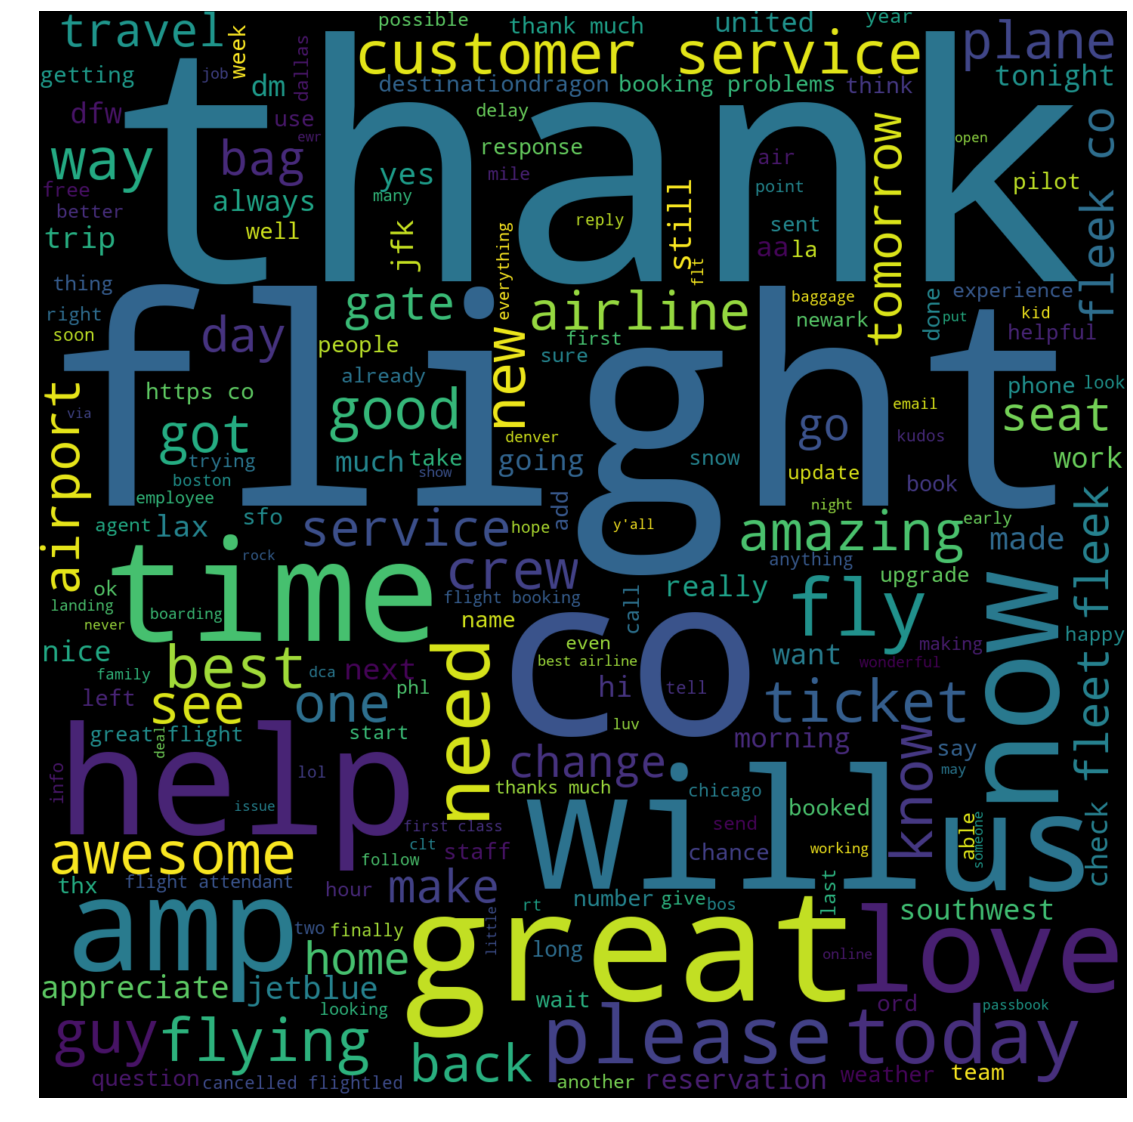

In [54]:
# wykres typu word cloud dla pozytywnych i neutralnych
positive = ' '.join(list(data_conf[data_conf['Opinion'] ==0]['text']))
pos_wc = WordCloud(width = 1440, height = 1440).generate(positive)
plt.figure(figsize=(20,20))
plt.imshow(pos_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

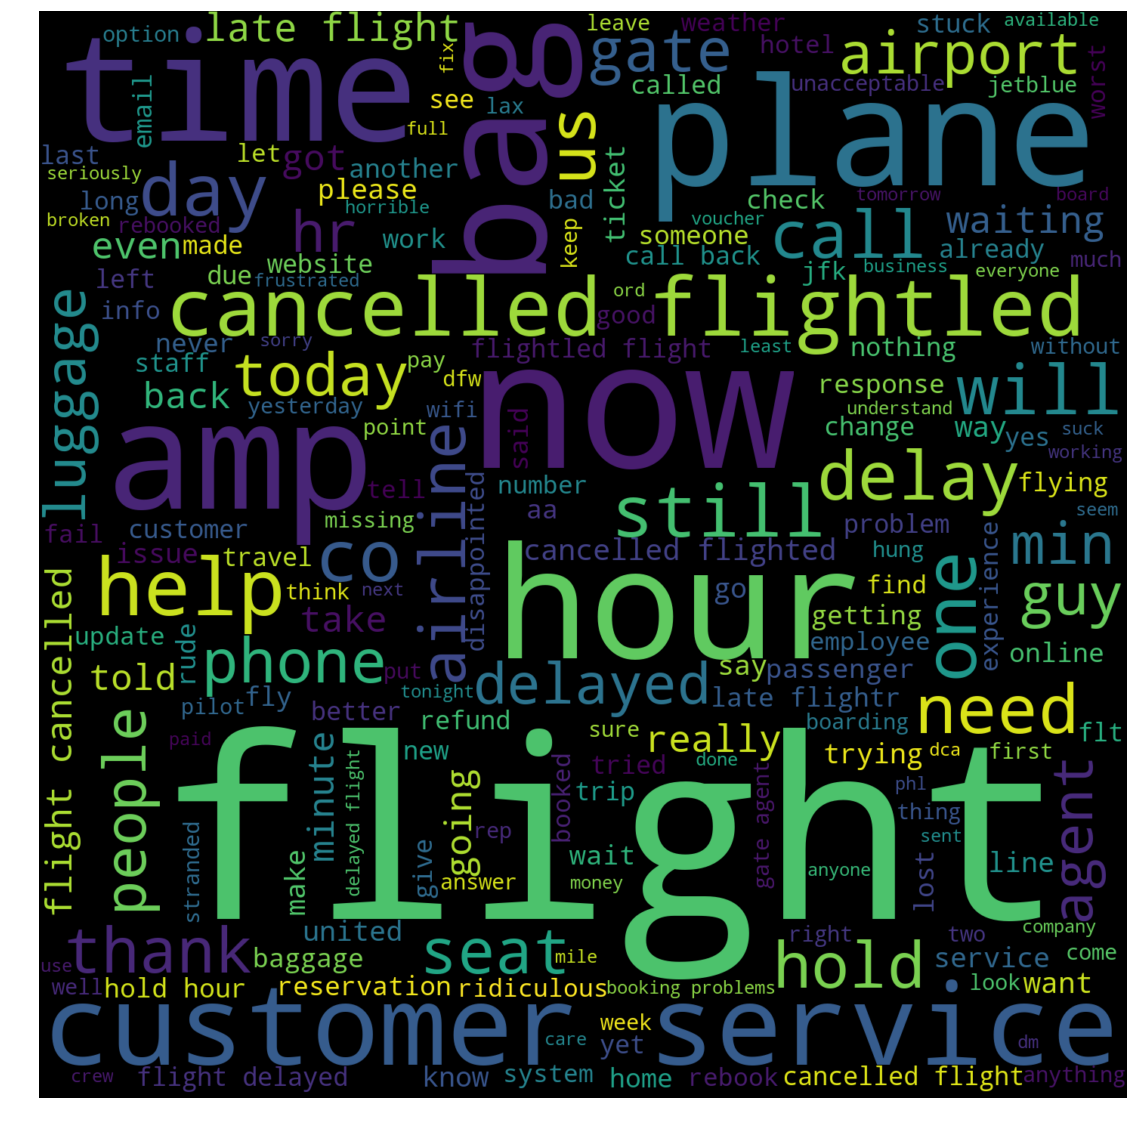

In [55]:
# wykres typu word cloud dla negatywnych
negative = ' '.join(list(data_conf[data_conf['Opinion'] ==1]['text']))
neg_wc = WordCloud(width = 1440, height = 1440).generate(negative)
plt.figure(figsize=(20,20))
plt.imshow(neg_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [56]:
#tokenizacja tekstu. Usunięcie znaków interpunkcyjnych i 'stop words'
nltk.download('stopwords')

def process_text(text):
    
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    return clean_words

# pokaż listę tokenów
data_conf['text'].head().apply(process_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m.materek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                                               [said]
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
5    [seriously, would, pay, 30, flight, seats, did...
9         [amazing, arrived, hour, early, youre, good]
Name: text, dtype: object

In [57]:
# wektoryzacja słów i podział zbioru na treningowy i testowy
messages_bow = CountVectorizer(analyzer=process_text).fit_transform(data_conf['text'])

X_train, X_test, y_train, y_test = train_test_split(messages_bow, data_conf['Opinion'], test_size = 0.20, random_state = 123)

In [58]:
# teraz wyuczę różne algorytmy klasyfikujące

# Klasyfikator SGD
sgd = linear_model.SGDClassifier()
sgd.fit(X_train, y_train)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)

# Klasyfikator las losowy
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)

# Regresja logistyczna
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)

# Klasyfikator k - najbliższych sasiadów
knn = KNeighborsClassifier() 
knn.fit(X_train, y_train)  
acc_knn = round(knn.score(X_train, y_train) * 100, 2)

# Maszyna wektorów nośnych
svc = SVC()
svc.fit(X_train, y_train)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)

# drzewo decyzyjne
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, y_train)  
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)

# zebranie wyników dla zbioru treningowego w jeden obiekt dataframe
wyniki = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest,
              acc_sgd, acc_decision_tree]})
wyniki_df = wyniki.sort_values(by='Score', ascending=False)
wyniki_df = wyniki_df.set_index('Score')
wyniki_df.head(6)

,Model
Score,
99.98,Decision Tree
99.11,Random Forest
97.76,Stochastic Gradient Decent
97.20,Logistic Regression
70.36,Support Vector Machines
66.68,KNN


In [59]:
# łooo, modele dały niesamowite wyniki, ale to chyba przetrenowanie, sprawdźmy jak radzą sobie na zbiorze testowym

acc_sgd = round(sgd.score(X_test, y_test) * 100, 2)

acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)

acc_log = round(logreg.score(X_test, y_test) * 100, 2)

acc_knn = round(knn.score(X_test, y_test) * 100, 2)

acc_svc = round(svc.score(X_test, y_test) * 100, 2)

acc_decision_tree = round(decision_tree.score(X_test, y_test) * 100, 2)

# zebranie wyników dla zbioru treningowego w jeden obiekt dataframe
wyniki = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest,
              acc_sgd, acc_decision_tree]})
wyniki_df = wyniki.sort_values(by='Score', ascending=False)
wyniki_df = wyniki_df.set_index('Score')
wyniki_df.head(6)

,Model
Score,
88.89,Logistic Regression
86.45,Stochastic Gradient Decent
85.26,Random Forest
83.77,Decision Tree
71.95,Support Vector Machines
54.38,KNN


In [60]:
# no i faktycznie. wyniki sa dużo słabsze, spróbujmy przeszukać siatkę parametrów dla wybranych algorytmów

# najpierw las losowy

#liczba drzew w lesie
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# liczba cech do rozważenia przy każdym podziale
max_features = ['auto', 'sqrt']
# maksymalna liczba poziomów w każdym drzewie
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimalna liczba cech przy każdym podziale
min_samples_leaf = [1, 2, 5, 10]
# Metoda wyboru przykładów do trenowania każdego drzewa
bootstrap = [True, False]

# Utworzenie siatki do losowego przeszukania
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 19.8min finished


{'n_estimators': 400,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [61]:
# teraz sgd classifier

grid = { 
  'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], # learning rate 
     'n_iter': [100, 1000, 10000, 100000], # number of epochs 
     'loss': ['log', 'modified_huber' ,'squared_hinge'], # logistic regression, 
     'penalty': ['l2', 'l1'] } 
 

sgd = linear_model.SGDClassifier()
sgd_random = RandomizedSearchCV(estimator = sgd, param_distributions = grid, n_iter = 50,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
sgd_random.fit(X_train, y_train)

sgd_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 36.0min finished


{'penalty': 'l2', 'n_iter': 10000, 'loss': 'log', 'alpha': 0.0001}

In [62]:
# maszyna vectorów nośnych

grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
        'tol' : [0.0001, 0.001, 0.01, 1],
        'kernel': ['rbf', 'poly'],
        'gamma': [0.01, 0.1, 1, 10 ,100]
        }
 
svc = SVC()
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = grid, n_iter = 50,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
svc_random.fit(X_train, y_train)

svc_random.best_params_ 

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  9.9min finished


{'tol': 0.0001, 'kernel': 'rbf', 'gamma': 0.1, 'C': 10}

In [65]:
# regresja logistyczna
grid = {"C":np.logspace(-4,4,9), 
        "penalty":["l1","l2"],
        'tol' : [0.0001, 0.001, 0.01, 1]
       }
 
log_reg = LogisticRegression()
log_reg_random = RandomizedSearchCV(estimator = log_reg, param_distributions = grid, n_iter = 50,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
log_reg_random.fit(X_train, y_train)

log_reg_random.best_params_ 

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.7s finished


{'tol': 0.01, 'penalty': 'l2', 'C': 1.0}

In [73]:
# wskaźniki dla lasu losowego dla optymalnych parametrów
rf = RandomForestClassifier(n_estimators = 400, bootstrap = False, min_samples_leaf = 1)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[ 436  150]
 [ 112 1391]]

Accuracy:  87.46


In [74]:
# wskaźniki klasyfikatora SGD
sgd = linear_model.SGDClassifier(n_iter = 10000, alpha = 0.0001, loss = 'log', penalty = 'l2')
sgd.fit(X_train, y_train)
pred = sgd.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[ 453  133]
 [ 102 1401]]

Accuracy:  88.75


In [75]:
# wskaźniki klasyfikatora SVC
svc = SVC(C = 10, tol = 0.0001, kernel = 'rbf', gamma = 0.1)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[ 426  160]
 [  87 1416]]

Accuracy:  88.18


In [76]:
# wskaźniki dla regresji logistycznej
log_reg = LogisticRegression(tol = 0.01, penalty = 'l2', C =1)
log_reg.fit(X_train, y_train)
pred = log_reg.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[ 451  135]
 [  97 1406]]

Accuracy:  88.89


In [82]:
# sprawdzenie wyników dla klasyfikatora głosującego
voting_clf = VotingClassifier(estimators=[('sgd', sgd), ('svc', svc), ('lr', log_reg)], voting='hard')
voting_clf.fit(X_train, y_train)

pred = voting_clf.predict(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', round(100*accuracy_score(y_test,pred),2))

Confusion Matrix: 
 [[ 451  135]
 [  99 1404]]

Accuracy:  88.8


In [83]:
# największą dokładnosć uzyskaliśmy (o dziwo!) dla regresji logistycznej, ale najwięcej negatywnych komentarzy wykrył
# algorytm support vector machine